# Introduction

## Project

This notebook is the work made for the final project of [Applied Data Science Capstone by IBM/Coursera](https://www.coursera.org/learn/applied-data-science-capstone).  

All project files are hosted on my dedicated [Github page](https://github.com/vanAkim/IBM_Data_Science_Professional_Certificate/tree/main/9-Capstone_Project/FinalProject).  

The report is embedded in the [README file](https://github.com/vanAkim/IBM_Data_Science_Professional_Certificate/blob/main/9-Capstone_Project/FinalProject/README.md), named as such to get better readability on Github repository page.

## Business problem

In this project we will try to find if cultural sites clusters exist in Toulouse, France.

And if so, are these cultural places more or less grouped according to their category?   
Also, pedestrian flow counted in Toulouse streets may have a correlation with the cultural category venues. Thus, we'll try to find if these data impact potential previous clustering.

Common data science workflow is used to get through the problematic and try to find answers. From collecting data with URL API request, heavy data cleaning process, most important exploratory data analysis plots since we're working with maps, and finally some machine learning clustering techniques are applied.


# Collected Data

+ The main points with their locations (latitude & longitude) and category, i.e. cultural places, will be retrieved from Foursquare databases using their API.   
+ On [Data.toulouse-metropole](https://data.toulouse-metropole.fr/explore/dataset/comptages-pietons/information/?sort=annee&location=16,43.60208,1.44634&basemap=jawg.streets) webpage a dataset is available which counts the pedestrian flows in different streets of Toulouse. This `comptages-pietons` dataset, from **Toulouse Métropole**, with last data input on **2020-02-13**, is made available under the [Open Database License](http://opendatacommons.org/licenses/odbl/1.0/) *([local license text](https://github.com/vanAkim/IBM_Data_Science_Professional_Certificate/blob/main/9-Capstone_Project/FinalProject/ODC%20Open%20Database%20License%20(ODbL).md))*. Any rights in individual contents of the database are licensed under the [Database Contents License](http://opendatacommons.org/licenses/dbcl/1.0/).

## Cultural venues in Toulouse

In [1]:
# Latitude and longitude of Toulouse center
lat_tls = 43.6016
lng_tls = 1.4407

### Request data from Foursquare API

Set parameters in the URL Foursquare API and requests the results.

In [2]:
import json, requests
url = 'https://api.foursquare.com/v2/venues/explore'

params = dict(
client_id='3HKNONV5WQ0YZJUOEYSE0221FMCZQDZHKNQ0W4ZG1P5XW2KW',
client_secret='0TIKF1OFORWQTIPFVVLMGHHQST3LPPTBLMKXATPVIUPFJXUU',
v='20180323',
ll=str(lat_tls) + ',' + str(lng_tls),
    
query='loisirs', # Ask for cultural venues, even if 'loisirs' in French means 'hobbies' 
                 # but that matches enough and that's the more appropriate Foursquare option
    
limit=200,
locale='fr',
radius=1800
)

resp = requests.get(url=url, params=params)
data = json.loads(resp.text)
items = data['response']['groups'][0]['items']

Turn the JSON results into a parsed pandas dataframe.

In [3]:
from pandas import json_normalize

dataframe = json_normalize(items) # flatten JSON

filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean columns
dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]

# Drop useless columns
dataframe_filtered.drop(columns=['labeledLatLngs','distance','postalCode','cc','city','state','country','formattedAddress','crossStreet','id'],
                       inplace=True)

dataframe_filtered.head()

,name,categories,address,lat,lng
0,Théâtre du Capitole,Opéra,Place du Capitole,43.604130,1.444332
1,Musée des Augustins,Musée d'art,21 Rue de Metz,43.601170,1.446397
2,Hôtel de Ville de Toulouse (Capitole),Hôtel de ville,Place du Capitole,43.604523,1.444179
3,Parc de la Prairie des Filtres,Parc,Cours Dillon,43.595638,1.436977
4,Rio Loco,Salle de concert,NaN,43.596345,1.436907


In [4]:
print("Number of collected sites :", dataframe_filtered.shape[0])

Number of collected sites : 29


### Data cleaning

For futher analysis, it's important to group *(also with english translation)* categories venues. Arbitrarily, I chose 4 major areas of clustering:
+ Activities offering a show *(cinema, theatre, spectacle, concert/festival)* : `show`
+ A place to visit: `monument`
+ Activities requiring play *(sport, danse, games, green/play grounds)*: `play`
+ Activities requiring interaction *(reading, moving, learning)*: `exposition-formation`

Some of these levels can be further divided with sub-categories according to the approach below:
+ Show: `spectacle`, `cinema`, `music`
+ Play: `sport`, `game`, `parc`

In [5]:
# Take a look at all the different categories
cat = dataframe_filtered['categories'].unique()
print("Number of different categories names:", len(cat), '\n\nAll categories:\n', cat)

Number of different categories names: 21 

All categories:
 ['Opéra' "Musée d'art" 'Hôtel de ville' 'Parc' 'Salle de concert'
 'Multiplexe' 'Théâtre' "Galerie d'art" 'Jardin' 'Cinéma indépendant'
 'Musée des sciences' 'Salle de spectacle' 'Base militaire' 'Église'
 "Musée d'histoire" 'Cinéma' 'Stade de basketball' 'Café des sports'
 'Auditorium' 'Complexe des arts de la\xa0scène' 'Salle de danse']


1. Group all the dataset categories and build a dict with the new levels.
2. Rename all categories in the dataframe with the previous clustering dict.

In [6]:
subcategorie_labels = {
    # Watch a show
    "spectacle": ["Opéra", "Théâtre", "Salle de spectacle", "Complexe des arts de la scène", "Complexe des arts de la\xa0scène"],
    "cinema": ["Multiplexe", "Cinéma indépendant", "Cinéma"],
    "music": ["Salle de concert", "Auditorium"],

    # Visit a place
    "monument": ["Hôtel de ville", "Base militaire", "Église", "Site historique"],

    # Play
    "sport": ["Stade de basketball", "Stade de football", "Café des sports", "Salle de danse", "Stade"],
    "game": ["Salle d'arcade", "Parc d'attractions"],

    # Interact with culture
    "exposition-formation": ["Musée d'art", "Musée des sciences", "Galerie d'art", "Musée d'histoire", "École"],

    # Enjoy green
    "parc": ["Parc", "Jardin"]
}

hicategorie_labels = {
    "show": ["spectacle", "cinema", "music"],
    "monument": ["monument"],
    "play": ["sport", "game", "parc"],
    "exposition-formation": ["exposition-formation"]
}

In [7]:
# All sub-categories names
for i, cat_val in enumerate(subcategorie_labels.values()):
    filt = list(map(lambda cat_venu: cat_venu in cat_val,
                    dataframe_filtered['categories']))
    dataframe_filtered.loc[filt,'categories'] = list(subcategorie_labels.keys())[i]

In [8]:
# All higher-categories names
for i, cat_val in enumerate(hicategorie_labels.values()):
    filt = list(map(lambda cat_venu: cat_venu in cat_val,
                    dataframe_filtered['categories']))
    dataframe_filtered.loc[filt,'hicategories'] = list(hicategorie_labels.keys())[i]

After clustering categories:

In [9]:
# Take a look at all the different categories
cat = dataframe_filtered['categories'].unique()
hicat = dataframe_filtered['hicategories'].unique()
print("Number of different sub-categories names:", len(cat), '\nAll catefories:\n', cat, '\n\n',
     "Number of different higher-categories names:", len(hicat), '\nAll catefories:\n', hicat)

Number of different sub-categories names: 7 
All catefories:
 ['spectacle' 'exposition-formation' 'monument' 'parc' 'music' 'cinema'
 'sport'] 

 Number of different higher-categories names: 4 
All catefories:
 ['show' 'exposition-formation' 'monument' 'play']


In [10]:
dataframe_filtered.head()

,name,categories,address,lat,lng,hicategories
0,Théâtre du Capitole,spectacle,Place du Capitole,43.604130,1.444332,show
1,Musée des Augustins,exposition-formation,21 Rue de Metz,43.601170,1.446397,exposition-formation
2,Hôtel de Ville de Toulouse (Capitole),monument,Place du Capitole,43.604523,1.444179,monument
3,Parc de la Prairie des Filtres,parc,Cours Dillon,43.595638,1.436977,play
4,Rio Loco,music,NaN,43.596345,1.436907,show


Let's see how much each category appears:

In [11]:
print("Sub-categories occurrence:\n" , dataframe_filtered['categories'].value_counts(),
     "\n\nHigher categories occurrence:\n", dataframe_filtered['hicategories'].value_counts())

Sub-categories occurrence:
 exposition-formation    6
music                   5
spectacle               5
cinema                  4
sport                   3
monument                3
parc                    3
Name: categories, dtype: int64 

Higher categories occurrence:
 show                    14
exposition-formation     6
play                     6
monument                 3
Name: hicategories, dtype: int64


**Such low occurrences, even for `show` category, prevent any statistical analysis, and probably isn't enough to create a performant clustering algorithm. Nonetheless, that's the data we have, so let's try to do something with it.**

### Exploratory visualization

#### Show venues on a map

In [71]:
import folium

toulouse_map = folium.Map(location=[lat_tls, lng_tls], zoom_start=15, tiles="cartoDB positron")

for lat, lng, name, cat in zip(dataframe_filtered['lat'], dataframe_filtered['lng'], dataframe_filtered['name'], dataframe_filtered['categories']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='#205E40',
        fill=True,
        opacity=0,
        fill_color='#3AAB74',
        fill_opacity=0.7,
        parse_html=False).add_to(toulouse_map)

toulouse_map

As said in the [README file](https://github.com/vanAkim/IBM_Data_Science_Professional_Certificate/blob/main/9-Capstone_Project/FinalProject/README.md), **there are few sites and since their distribution is quite wide without any obvious pattern (though, there seems to be a little trend at the top right), a clustering only by their geographical location seems irrelevant.**  
Let's review the previous map, distinguishing the different categories by color.

#### Category color distinction

##### Sub-levels

Create a dict of qualitative color from `tab10` cmap where keys are categories names:

In [13]:
from matplotlib import cm

keys = list(dataframe_filtered['categories'].unique())
color_range = list(np.linspace(0, 1, len(keys), endpoint=False))

colors = [cm.colors.to_hex(cm.tab10(x)) for x in color_range]
color_dict = dict(zip(keys, colors)) 

Create a dict of folium FeatureGroup to add on another map layer which could work as a legend map:

In [14]:
categories = dataframe_filtered['categories'].unique()
folium_lgd = dict()
for col, cat in zip(colors, categories):
    folium_lgd[cat] = folium.FeatureGroup(name='<span style=\\"color: {col};\\">{cat}</span>'.format(col=col, cat=cat))

Create the map and add circle markers to localize each Foursquare sites:

In [15]:
toulouse_map = folium.Map(location=[lat_tls, lng_tls], zoom_start=15, tiles="cartoDB positron")

for lat, lng, name, cat in zip(dataframe_filtered['lat'], dataframe_filtered['lng'],
                               dataframe_filtered['name'], dataframe_filtered['categories']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=9,
        popup=label,
        fill=True,
        opacity=0,
        fill_color=color_dict[cat],
        fill_opacity=0.8,
        parse_html=False).add_to(folium_lgd[cat])
    folium_lgd[cat].add_to(toulouse_map)

folium.map.LayerControl('topright', collapsed=False).add_to(toulouse_map)
    
toulouse_map

**There is too little data for all of these categories, so it is more appropriate to use `hicategories` as labeling categories to avoid unnecessary labeling spread:**

##### Higer levels

In [16]:
## Same code as before with 'categories' replaced by 'hicategories'

# Color array by categories
keys = list(dataframe_filtered['hicategories'].unique())
color_range = list(np.linspace(0, 1, len(keys), endpoint=False))

colors = [cm.colors.to_hex(cm.tab10(x)) for x in color_range]
color_dict = dict(zip(keys, colors)) 

# ------------------------------
# Create FeatureGroup to add a legend layer
categories = dataframe_filtered['hicategories'].unique()
folium_lgd = dict()
for col, cat in zip(colors, categories):
    folium_lgd[cat] = folium.FeatureGroup(name='<span style=\\"color: {col};\\">{cat}</span>'.format(col=col, cat=cat))

# ------------------------------
# Generate the map
toulouse_map = folium.Map(location=[lat_tls, lng_tls], zoom_start=15, tiles="cartoDB positron")

for lat, lng, name, cat in zip(dataframe_filtered['lat'], dataframe_filtered['lng'],
                               dataframe_filtered['name'], dataframe_filtered['hicategories']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=9,
        popup=label,
        fill=True,
        opacity=0,
        fill_color=color_dict[cat],
        fill_opacity=0.8,
        parse_html=False).add_to(folium_lgd[cat])
    folium_lgd[cat].add_to(toulouse_map)

folium.map.LayerControl('topright', collapsed=False).add_to(toulouse_map)
    
toulouse_map

+ **Even if `show` is predominant and bias the view of the map, it seems that `show` venues are more located on the upper right of downtown.**
+ **Other categories are much more difficult to judge because each has too small occurrences.**  

## Pedestrian flows dataset

As mentioned in the [README file](https://github.com/vanAkim/IBM_Data_Science_Professional_Certificate/blob/main/9-Capstone_Project/FinalProject/README.md), **in order to potentially add another useful value to the clustering algorithm, a pedestrian flow counts is read and add along venue locations dataset.**


### Download and read data

In [17]:
import geopandas
import pandas as pd

url = "https://data.toulouse-metropole.fr/explore/dataset/comptages-pietons/download/?format=geojson&timezone=Europe/Berlin&lang=fr"

tls_pedestrian = geopandas.read_file(url)

In [18]:
tls_pedestrian.head()

,moment_dans_la_journee,comptage,adresse,transposee,jours,annee,geometry
0,midi,893,devant la brasserie rue Bayard,semaine_midi_2006,semaine,2006.0,POINT (1.44588 43.60783)
1,midi,700,devant la brasserie rue Bayard,samedi_midi_2015,samedi,2015.0,POINT (1.44588 43.60783)
2,soir,854,devant la brasserie rue Bayard,semaine_soir_2013,semaine,2013.0,POINT (1.44588 43.60783)
3,soir,1178,devant la brasserie rue Bayard,samedi_soir_2013,samedi,2013.0,POINT (1.44588 43.60783)
4,soir,925,devant la brasserie rue Bayard,samedi_soir_2012,samedi,2012.0,POINT (1.44588 43.60783)


### Data cleaning

The above steps are done to make the dataset relevant in this workflow:
1. Remove useless features.
2. Get recent datetime values, with older year measurement set as 2015.
3. Get the literal latitude and longitude of the measurement point, from the geojson `geometry` object.
4. Cast the appropriate features types.
5. Translate / rename the features.
6. Regroup `moment_dans_la_journee` *(en: daytime)* values as `day` or `night`levels. *(Note: this feature is relatively useless, in doubt it'll stay)*

In [19]:
# Remove useless features
tls_pedestrian.drop(["transposee", "jours"], axis=1, inplace=True)


# Slice most recent data
filt = tls_pedestrian['annee'] >= 2015
tls_pedestrian = tls_pedestrian.loc[filt]


# Transform geometry feature type into a simple lat-lng list
tls_pedestrian['latitude'] = tls_pedestrian['geometry'].bounds['miny']
tls_pedestrian['longitude'] = tls_pedestrian['geometry'].bounds['minx']


# Change features types and names
tls_pedestrian['comptage'] = tls_pedestrian['comptage'].astype(int)
tls_pedestrian['annee'] = tls_pedestrian['annee'].astype(str)
tls_pedestrian['latitude'] = tls_pedestrian['latitude'].astype(str)
tls_pedestrian['longitude'] = tls_pedestrian['longitude'].astype(str)

tls_pedestrian.columns = ["day_time", "count", "address", "year", "geometry", "latitude", "longitude"]


# Format day_time feature labels
day_lab = ["journee", "midi", "matin"]
tls_pedestrian["day_time"] = list(map(lambda time: 'day' if time in day_lab else 'night',
                                      tls_pedestrian["day_time"]))


# ------------------------------
# Clean the index
tls_pedestrian.reset_index(drop=True, inplace=True)

# Overview
tls_pedestrian.head()

,day_time,count,address,year,geometry,latitude,longitude
0,day,700,devant la brasserie rue Bayard,2015.0,POINT (1.44588 43.60783),43.60782556389234,1.445876790590295
1,day,1058,devant la brasserie rue Bayard,2016.0,POINT (1.44588 43.60783),43.60782556389234,1.445876790590295
2,day,436,devant la brasserie rue Bayard,2018.0,POINT (1.44588 43.60783),43.60782556389234,1.445876790590295
3,day,232,devant la brasserie rue Bayard,2016.0,POINT (1.44588 43.60783),43.60782556389234,1.445876790590295
4,day,227,devant la brasserie rue Bayard,2015.0,POINT (1.44588 43.60783),43.60782556389234,1.445876790590295


In [20]:
print("Number of measurements:", tls_pedestrian.shape[0], "counts in", 
      len(tls_pedestrian["address"].unique()), "differents streets over",
     len(tls_pedestrian["year"].unique()), "years")

Number of measurements: 3136 counts in 96 differents streets over 5 years


### Exploratory visualization

#### Aggregate data by years and adress

Since pedestrian flow count is calculated among all years *(i.e. 2015-2019)*: 
1. The dataset is grouped by address and year.
2. Null values are removed.
3. `count` median value is taken in account.

In [21]:
# Grouping by addresses and years
tls_ped_grpby = tls_pedestrian.groupby(['address', 'year'], as_index=False).median()

# Remove null values
filt = tls_ped_grpby['count'] != 0
tls_ped_grpby = tls_ped_grpby[filt]

# Median values between years
tls_ped_grpby = tls_ped_grpby.groupby(['address'], as_index=False).median().round()


# ------------------------------
# Store and clean the final dataset 'tls_ped_grpby' without replacing the original 'tls_pedestrian'
tls_ped_grpby = tls_ped_grpby.join(
    tls_pedestrian[['address','latitude','longitude']].drop_duplicates().set_index('address'),
    on="address")

tls_ped_grpby.drop_duplicates('address', inplace=True) # step needed because weirdly 3 measures are 'address' duplicates, which should not be the case at this point,
                                                       # but exist because lat&lng are different from the same 'address' to another, which are authors mistakes


# ------------------------------
# Overview
print("Number of measurements:", tls_ped_grpby.shape[0], "counts in", 
      len(tls_ped_grpby["address"]), "streets")

Number of measurements: 79 counts in 79 streets


In [22]:
tls_ped_grpby.head()

,address,count,latitude,longitude
0,1 Rue Bayard,812.0,43.60824205958672,1.446576244291821
1,1 passage de l'hôtel de Ville,102.0,43.60456740686743,1.444621823413681
2,1 place Jeanne d'Arc,2430.0,43.60857631673823,1.44587074534944
3,1 rue d'Austerlitz,952.0,43.60544214882909,1.447397826384669
4,10 rue des Lois,698.0,43.60515870014418,1.44227143410786


In [23]:
tls_ped_grpby.describe()

,count
count,79.000000
mean,996.126582
std,707.170153
min,25.000000
25%,482.500000
50%,888.000000
75%,1395.500000
max,3016.000000


#### Show pedestrian flow counts on a map

In [72]:
import branca

# Hex color function to transform values from specified cmap, here Oranges
colorscale = branca.colormap.linear.Greys_09.scale(tls_ped_grpby['count'].min(), tls_ped_grpby['count'].max())

# ------------------------------
# Create FeatureGroup to add a legend layer
folium_lgd = dict()
for col, cat in zip(colors, categories):
    folium_lgd[cat] = folium.FeatureGroup(name='<span style=\\"color: {col};\\">{cat}</span>'.format(col=col, cat=cat))

# ------------------------------

# Initial layout map
toulouse_map = folium.Map(location=[lat_tls, lng_tls], zoom_start=15, tiles="cartoDB positron")

# Adding counted pedestrian spots with circles
for lat, lng, address, count in zip(tls_ped_grpby['latitude'], tls_ped_grpby['longitude'], tls_ped_grpby['address'], tls_ped_grpby['count']):
    label = '{} | Count : {}'.format(address, int(count))
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [float(lat), float(lng)],
        radius=(count/250)+4,
        popup=label,
        color='#F5B254',
        opacity=0.5,
        fill=True,
        fill_color=colorscale(count),
        fill_opacity=0.8,
        parse_html=False).add_to(toulouse_map)

# Show map
toulouse_map

**Once again, this number of measurements is relatively low, but above all the distribution of points is directed and not homogeneous.** 

This certainly distorts the real representation of the flow of pedestrians in Toulouse. Especially since I live in this city, I know that the agglomerations of the measurement points at the "Capitole" (historical center among others), "Esquirol" (commercial streets) and "Les Carmes" / "Daurade" (bars & pubs) are cleverly chosen since they are the densest crossing points in the city.

In this sense, the primary goal of this dataset must be to mainly measure the streets with the most important pedestrian flows. Which isn't helpful with your problematic, especially with the previous Foursquare collected sites already biased.  

That's why I was precautious in the problematic development. Since I had the intuition of not being the most relevant dataset when I was searching and gathering intels to go along Foursquare points. Now, this little exploratory visualization confirms my first impressions. **However, these data is unique and the only one available of it's kinds. So I'll keep going on and try to get the most I can from it. We have the data available and not always the appropriate.**

#### Pedestrian flow counts and cultural venues map

In [25]:
# Create FeatureGroup to add a legend layer
folium_lgd = dict()
for col, cat in zip(colors, categories):
    folium_lgd[cat] = folium.FeatureGroup(name='<span style=\\"color: {col};\\">{cat}</span>'.format(col=col, cat=cat))

# ------------------------------

# Initial layout map
toulouse_map = folium.Map(location=[lat_tls, lng_tls], zoom_start=15, tiles="cartoDB positron")

# Adding counted pedestrian spots with circles
for lat, lng, address, count in zip(tls_ped_grpby['latitude'], tls_ped_grpby['longitude'], tls_ped_grpby['address'], tls_ped_grpby['count']):
    label = '{} | Count : {}'.format(address, int(count))
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [float(lat), float(lng)],
        radius=(count/250)+4,
        popup=label,
        color='#F5B254',
        opacity=0.4,
        fill=True,
        fill_color=colorscale(count),
        fill_opacity=0.8,
        parse_html=False).add_to(toulouse_map)

# Adding cultural venues
for lat, lng, name, cat in zip(dataframe_filtered['lat'], dataframe_filtered['lng'],
                               dataframe_filtered['name'], dataframe_filtered['hicategories']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=9,
        popup=label,
        fill=True,
        opacity=0,
        fill_color=color_dict[cat],
        fill_opacity=0.7,
        parse_html=False).add_to(folium_lgd[cat])
    folium_lgd[cat].add_to(toulouse_map)

folium.map.LayerControl('topright', collapsed=False).add_to(toulouse_map)

# Show map
toulouse_map

Nothing new here, high density pedestrian flows and `show` are more visible on the upper right part of the city, as previously mentioned. And even if there are probably correlated, that's mostly the bias effect resulting of original datasets. 

#### Proximity pedestrian flow counts

##### Proximity areas

The chosen way to link the two databases is to select the nearest pedestrian flow metrics from each Foursquare site. For this, it is necessary to define a proximity criterion.  
Here, this criterion will be a simple disk area centered on the different cultural places. If a point is present in an area of a disk, then it will be defined as being near the site at the center of the disk.

The radius of this area is determined subjectively with an interactive slider. After a few tests, an area with a radius of 140 meters seems to be suitable for being a relatively narrow perimeter but sufficient to include a minimum number of points.

In [26]:
import ipywidgets

In [27]:
# Run this cell (change the slider value if needed) and the above one, 
# then use the slider to change radius value without rerunning the cell
# but map rendering cell (above) need to be rerun to take the new value

int_range_slider = ipywidgets.IntSlider(value=140, min=0, max=500, step=5)
int_range_slider

IntSlider(value=140, max=500, step=5)

Display of the previous map with the radius discs chosen with the slider above:

In [28]:
# ------------------------------
# Create FeatureGroup to add a legend layer
folium_lgd = dict()
for col, cat in zip(colors, categories):
    folium_lgd[cat] = folium.FeatureGroup(name='<span style=\\"color: {col};\\">{cat}</span>'.format(col=col, cat=cat))

# ------------------------------

# Initial layout map
toulouse_map = folium.Map(location=[lat_tls, lng_tls], zoom_start=15, tiles="cartoDB positron")

# Adding cultural venues radius
for lat, lng, name, cat in zip(dataframe_filtered['lat'], dataframe_filtered['lng'], dataframe_filtered['name'], dataframe_filtered['categories']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=int_range_slider.value,
        fill=True,
        opacity=0,
        fill_color='#F09122',
        fill_opacity=0.5,
        parse_html=False).add_to(toulouse_map)

# Adding counted pedestrian spots with circles
for lat, lng, address, count in zip(tls_ped_grpby['latitude'], tls_ped_grpby['longitude'], tls_ped_grpby['address'], tls_ped_grpby['count']):
    label = '{} | Count : {}'.format(address, int(count))
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [float(lat), float(lng)],
        radius=(count/250)+4,
        popup=label,
        color='#F5B254',
        opacity=0.4,
        fill=True,
        fill_color=colorscale(count),
        fill_opacity=0.8,
        parse_html=False).add_to(toulouse_map)

# Adding cultural venues
for lat, lng, name, cat in zip(dataframe_filtered['lat'], dataframe_filtered['lng'],
                               dataframe_filtered['name'], dataframe_filtered['hicategories']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=9,
        popup=label,
        fill=True,
        opacity=0,
        fill_color=color_dict[cat],
        fill_opacity=0.8,
        parse_html=False).add_to(folium_lgd[cat])
    folium_lgd[cat].add_to(toulouse_map)

folium.map.LayerControl('topright', collapsed=False).add_to(toulouse_map)

# Show map
toulouse_map

##### Distances between all locations

Now we need to calculate the distance between each Foursquare location and all the pedestrian flow measurement locations.

In [29]:
import geopy.distance

# Select 
dist_venu_ped = dataframe_filtered[['name', 'lat', 'lng']]

# geopy.distance fct need a tuple of lat and lng, so a dedicated column is created
dist_venu_ped['coord'] = list(zip(dist_venu_ped['lat'], dist_venu_ped['lng']))

# For each Foursquare venue, distances with all ped flows are calculated
tempo = pd.DataFrame()
i = 0
for lat, lng in zip(tls_ped_grpby['latitude'], tls_ped_grpby['longitude']):
    tempo[i] = list(map(lambda coord: geopy.distance.geodesic(coord, (lat,lng)).meters,
                        dist_venu_ped['coord']))
    i += 1

# Store in columns named as ped flow addresses, all the distances calculated
tempo.columns = tls_ped_grpby['address']
tempo = tempo.applymap(int)

# Merge initial Foursquare venues df with the above distance df
dist_venu_ped = pd.concat([dist_venu_ped, tempo], axis='columns')

# Overview
dist_venu_ped.head()

<ipython-input-29-d1090d599afd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dist_venu_ped['coord'] = list(zip(dist_venu_ped['lat'], dist_venu_ped['lng']))


,name,lat,lng,coord,1 Rue Bayard,1 passage de l'hôtel de Ville,1 place Jeanne d'Arc,1 rue d'Austerlitz,10 rue des Lois,10 rue des Tourneurs,...,Rue du Pont St Pierre,Viguerie,allée Jean Jaurès,devant la brasserie rue Bayard,face 14 rue Malbec,face au tabac le Myrtil place,rue Bayard,rue Deville,rue Valade,rue de Metz
0,Théâtre du Capitole,43.604130,1.444332,"(43.60412979544746, 1.4443320035934446)",491,53,509,287,201,486,...,1013,845,674,429,386,760,722,341,641,537
1,Musée des Augustins,43.601170,1.446397,"(43.6011697382502, 1.4463973045349119)",785,403,824,481,554,176,...,1076,930,804,740,508,437,962,659,874,434
2,Hôtel de Ville de Toulouse (Capitole),43.604523,1.444179,"(43.60452250885116, 1.4441793068247002)",456,36,470,279,169,531,...,1023,853,662,391,402,804,693,318,630,572
3,Parc de la Prairie des Filtres,43.595638,1.436977,"(43.59563769241053, 1.4369773864746094)",1600,1168,1606,1376,1140,813,...,570,603,1751,1532,783,692,1837,1090,948,582
4,Rio Loco,43.596345,1.436907,"(43.59634529848775, 1.4369071512699405)",1535,1105,1539,1318,1070,776,...,502,526,1697,1466,711,681,1774,1016,869,525


Select only the addresses with pedestrian flow counts locations in disk areas:

In [30]:
# For all addresses (start col 4), 
# is the distance less than or equal to the radius of the proximity area ?
filt = dist_venu_ped.iloc[:,4:] <= int_range_slider.value

# Filter addresses which aren't close enough from at least to 1 venue
filt = filt.sum() >= 1
prox_venu_ped = tls_ped_grpby[filt.reset_index(drop=True)] # need to drop the addresses index so it can be pass to the df

# Overview
print("From", tls_ped_grpby.shape[0], "flows counts,", 
      prox_venu_ped.shape[0], "where close enough.")

From 79 flows counts, 29 where close enough.


Here's the map with data points filtered:

In [31]:
# ------------------------------
# Create FeatureGroup to add a legend layer
folium_lgd = dict()
for col, cat in zip(colors, categories):
    folium_lgd[cat] = folium.FeatureGroup(name='<span style=\\"color: {col};\\">{cat}</span>'.format(col=col, cat=cat))

# ------------------------------

# Initial layout map
toulouse_map = folium.Map(location=[lat_tls, lng_tls], zoom_start=15, tiles="cartoDB positron")

# Adding cultural venues radius
for lat, lng, name, cat in zip(dataframe_filtered['lat'], dataframe_filtered['lng'], dataframe_filtered['name'], dataframe_filtered['categories']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=int_range_slider.value,
        fill=True,
        opacity=0,
        fill_color='#F09122',
        fill_opacity=0.5,
        parse_html=False).add_to(toulouse_map)

# Adding counted pedestrian spots at Foursquare venues proximity
for lat, lng, address, count in zip(prox_venu_ped['latitude'], prox_venu_ped['longitude'], prox_venu_ped['address'], prox_venu_ped['count']):
    label = '{} | Count : {}'.format(address, int(count))
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [float(lat), float(lng)],
        radius=(count/250)+4,
        popup=label,
        color='#F5B254',
        opacity=0.4,
        fill=True,
        fill_color=colorscale(count),
        fill_opacity=0.8,
        parse_html=False).add_to(toulouse_map)

# Adding cultural venues
for lat, lng, name, cat in zip(dataframe_filtered['lat'], dataframe_filtered['lng'],
                               dataframe_filtered['name'], dataframe_filtered['hicategories']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=9,
        popup=label,
        fill=True,
        opacity=0,
        fill_color=color_dict[cat],
        fill_opacity=0.8,
        parse_html=False).add_to(folium_lgd[cat])
    folium_lgd[cat].add_to(toulouse_map)

folium.map.LayerControl('topright', collapsed=False).add_to(toulouse_map)

# Show map
toulouse_map

##### Filter Foursquare sites from proximity pedestrian flow counts

In [32]:
# For all addresses (start col 4), 
# is the distance less than or equal to the radius of the proximity area ?
filt = dist_venu_ped.iloc[:,4:] <= int_range_slider.value

# Filter Foursquare venues which aren't close enough from at least to 1 venue
filt = filt.sum(1) >= 1
venu_prox = dataframe_filtered[filt].reset_index(drop=True)

# Overview
print("From", dataframe_filtered.shape[0], "Foursquare initial cultural venues,", 
      venu_prox.shape[0], "where close to at least 1 pedestrian flow count.")

From 29 Foursquare initial cultural venues, 12 where close to at least 1 pedestrian flow count.


Here's the map with pedestrian flows points filtered, as well as selected cultural places:

In [33]:
# ------------------------------
# Create FeatureGroup to add a legend layer
folium_lgd = dict()
for col, cat in zip(colors, categories):
    folium_lgd[cat] = folium.FeatureGroup(name='<span style=\\"color: {col};\\">{cat}</span>'.format(col=col, cat=cat))

# ------------------------------

# Initial layout map
toulouse_map = folium.Map(location=[lat_tls, lng_tls], zoom_start=15, tiles="cartoDB positron")

# Adding cultural venues radius
for lat, lng, name, cat in zip(venu_prox['lat'], venu_prox['lng'], venu_prox['name'], venu_prox['categories']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=int_range_slider.value,
        fill=True,
        opacity=0,
        fill_color='#F09122',
        fill_opacity=0.5,
        parse_html=False).add_to(toulouse_map)

# Adding counted pedestrian spots at Foursquare venues proximity
for lat, lng, address, count in zip(prox_venu_ped['latitude'], prox_venu_ped['longitude'], prox_venu_ped['address'], prox_venu_ped['count']):
    label = '{} | Count : {}'.format(address, int(count))
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [float(lat), float(lng)],
        radius=(count/250)+4,
        popup=label,
        color='#F5B254',
        opacity=0.4,
        fill=True,
        fill_color=colorscale(count),
        fill_opacity=0.8,
        parse_html=False).add_to(toulouse_map)

# Adding cultural venues
for lat, lng, name, cat in zip(venu_prox['lat'], venu_prox['lng'],
                               venu_prox['name'], venu_prox['hicategories']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=9,
        popup=label,
        fill=True,
        opacity=0,
        fill_color=color_dict[cat],
        fill_opacity=0.8,
        parse_html=False).add_to(folium_lgd[cat])
    folium_lgd[cat].add_to(toulouse_map)

folium.map.LayerControl('topright', collapsed=False).add_to(toulouse_map)

# Show map
toulouse_map

#### Data points adjustments

Quick summary :
* `dataframe_filtered`: all cultural Foursquare venues dataframe
* `tls_ped_grpby`: all pedestrian flow counts grouped by addresses and year dataframe
* `venu_prox`: cultural Foursquare venues filtered by proximity criterion dataframe
* `prox_venu_ped`: pedestrian flow counts filtered by proximity criterion dataframe

In order to get a better analysis workflow, let's make some adjustements with the data points.
1. On proximity venues categories, `monument` is single, it will be better to rebrand it with to a more relevant category from the two others reamining, which in this case is `exposition-formation`
2. Regroup dataframes
3. Set metrics of pedestrian flows for each venues, like the value of the nearest point or the median of all proximity points

In [34]:
# Replace the last "monument" category as "exposition-formation"
filt = venu_prox['hicategories'] == "monument"
venu_prox.loc[filt, 'hicategories'] = "exposition-formation"

# Remaining higher levels categories
print(venu_prox['hicategories'].unique())

['show' 'exposition-formation']


In [35]:
# Filters to select proximity venues and flows counts addresses
filt = dist_venu_ped.iloc[:,4:] <= int_range_slider.value
filt_venu = filt.sum(1) >= 1

# ------------------------------
# Apply filters
dist_prox = dist_venu_ped
dist_prox.iloc[:,4:] = dist_venu_ped.iloc[:,4:][filt]

# ------------------------------
# Set flow count metrics per venue

# Closest location flow count
filt_min = dist_prox.iloc[:,4:].idxmin(1).dropna()
venu_prox['min_pedcount'] = prox_venu_ped.set_index('address').loc[filt_min, 'count'].reset_index(drop=True)

# Median flow count
# weird way, but my brain can't figure out different way for now
for i, row in enumerate(filt[filt_venu].T): #from proximate flow count (filt), get the rows (T) of proximate venues (filt_venu)
    filt_med = filt[filt_venu].columns[filt.iloc[row,:]]
    venu_prox.loc[i, 'median_pedcount'] = prox_venu_ped.set_index('address').loc[filt_med, 'count'].median()

# ------------------------------
# Adding a dummy variable, which points if 'hicategories' is a show (1) or not (0, ⇔ 'exposition-formation')
venu_prox['show_cat'] = (venu_prox['hicategories'] == "show")*1

In [36]:
venu_prox.head()

,name,categories,address,lat,lng,hicategories,min_pedcount,median_pedcount,show_cat
0,Théâtre du Capitole,spectacle,Place du Capitole,43.604130,1.444332,show,2082.0,1809.0,1
1,Musée des Augustins,exposition-formation,21 Rue de Metz,43.601170,1.446397,exposition-formation,492.0,812.0,0
2,Hôtel de Ville de Toulouse (Capitole),monument,Place du Capitole,43.604523,1.444179,exposition-formation,102.0,1945.5,0
3,Fondation Bemberg,exposition-formation,Hôtel d'Assézat,43.600408,1.441880,exposition-formation,954.0,954.0,0
4,Gaumont Wilson,cinema,3 place du Président Thomas Wilson,43.604251,1.448624,show,580.0,1354.0,1


# Analysis

## Machine Learning clustering

I found 2 clustering algorithms suited well to our problem: hierarchical clustering and DBScan method.  

### Only by latitude and longitude

#### Hierarchical clustering

From scikit-learn library, the hierarchical clustering function need 2 main parameters: linkage method choice and number of clusters.   
To get some appropriate parameters to pass to the model fitting function, a dendrogram is plotted for each linkage method and the number of clusters is chosen from the more obvious threshold hierarchical distance.  

Since, "obvious" could be difficult to spot, a collection of clusters number is gathered for relatively different "obvious" threshold hierarchical distances. So, a table is manually written to put together possibles number of clusters and the better choice.

##### Best fit

Keeping all dendrograms is unnecessary and taking too much space, so I'll only plot one iteration but rerun every case to build the recap table.

<ipython-input-37-ebcbb1e2c28f>:7: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(dist_matrix, 'ward')


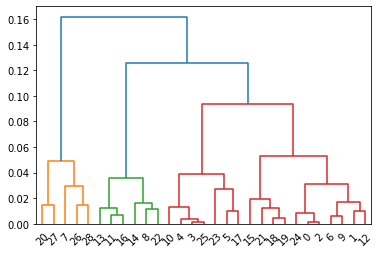

In [37]:
from scipy.cluster import hierarchy
from scipy.spatial import distance_matrix

X1 = dataframe_filtered[['lat','lng']]

dist_matrix = distance_matrix(X1,X1)
Z = hierarchy.linkage(dist_matrix, 'ward')
dendro = hierarchy.dendrogram(Z)

Linkage method | Working clusters numbers
:-----         | :----:
Ward           | [2,3,4] - Better:4
Complete       | [2,3,4,5] - Better:3
Average        | [2,3,5] - Better:5

From all cases, `ward` linkage method with 4 clusters seems to be a better good choice.

##### Fitting model

In [38]:
from sklearn.cluster import AgglomerativeClustering

# ML algo
agglom = AgglomerativeClustering(n_clusters = 4, linkage = 'ward')
agglom.fit(dataframe_filtered[['lat','lng']])

# Allocate cluster labels
dataframe_filtered['hier_cluster_lab'] = agglom.labels_

# Sort df to create a legend map ordered
dataframe_filtered.sort_values('hier_cluster_lab', inplace=True)

##### Results

In [39]:
# Create empty canvas
pivot_df = pd.DataFrame(index=dataframe_filtered['hier_cluster_lab'].unique(),
                        columns=dataframe_filtered['hicategories'].unique()).sort_index()

# Get counts by category and cluster label
count_lab = dataframe_filtered[['hicategories','hier_cluster_lab']].value_counts()

# Fill pivot table with counts
for num, idx in enumerate(count_lab.index):
    pivot_df.loc[idx[1], idx[0]] = count_lab[num]

# Adding marginal values
pivot_df.at['Sum',:] = pivot_df.sum()
pivot_df.at[:,'Sum'] = pivot_df.sum(1).astype(int)

# Contingency table
prop_pivot_df = pivot_df.iloc[0:4,0:5] / pivot_df.iloc[0:4,0:5].sum()

Next are tables (absolute and relative) showing how much each venue category is divided among the 4 different cluster (cluster labels are tables indexes).

In [40]:
# Absolute table
pivot_df

,play,show,exposition-formation,monument,Sum
0,2,2,1,NaN,5
1,NaN,8,2,1,11
2,2,2,1,1,6
3,2,2,2,1,7
Sum,6,14,6,3,29


In [41]:
# Proportion table
prop_pivot_df

,play,show,exposition-formation,monument,Sum
0,0.333333,0.142857,0.166667,NaN,0.172414
1,NaN,0.571429,0.333333,0.333333,0.379310
2,0.333333,0.142857,0.166667,0.333333,0.206897
3,0.333333,0.142857,0.333333,0.333333,0.241379


The map view of each venue colored by their cluster group is giving an interesting cleavage:

In [42]:
# ------------------------------
keys = list(dataframe_filtered['hier_cluster_lab'].unique())
color_range = list(np.linspace(0, 1, len(keys), endpoint=False))

colors = [cm.colors.to_hex(cm.tab10(x)) for x in color_range]
color_dict = dict(zip(keys, colors)) 

# ------------------------------
# Create FeatureGroup to add a legend layer
folium_lgd = dict()
for col, cat in zip(colors, keys):
    folium_lgd[cat] = folium.FeatureGroup(name='<span style=\\"color: {col};\\">Cluster {cat}</span>'.format(col=col, cat=cat))

# ------------------------------

# Initial layout map
toulouse_map = folium.Map(location=[lat_tls, lng_tls], zoom_start=15, tiles="cartoDB positron")

# Adding cultural venues
for lat, lng, name, cat, clust in zip(dataframe_filtered['lat'], dataframe_filtered['lng'],
                               dataframe_filtered['name'], dataframe_filtered['hicategories'],
                               dataframe_filtered['hier_cluster_lab']):
    label = '{} | {}'.format(name, cat)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=9,
        popup=label,
        fill=True,
        opacity=0,
        fill_color=color_dict[clust],
        fill_opacity=0.8,
        parse_html=False).add_to(folium_lgd[clust])
    folium_lgd[clust].add_to(toulouse_map)

folium.map.LayerControl('topright', collapsed=False).add_to(toulouse_map)

# Show map
toulouse_map

##### Discussion

With this method, taking into account only the geographical aspect without the cultural category of each place, the grouping seems surprisingly adequate.  
Generally speaking each category seems distributed with a dominance in one specific cluster. 

However, as specified during data collection, due to the representation bias of each category *(14-6-6-3)* and their very low occurrences, clustering is necessarily less suited to certain category (such as `monument` which only has a total of 3 places).

We find again an upper right cluster, the number 1, which includes 8 *(57%)* of `show` venues. This group is strongly linked both to the geographical layout and also to the presence of `show` sites. While for the other clusters, the geographical aspect seems to have a more important place in view of the distribution of categories.

> *So from the first part of the original problematic,*  
**since there are clusters of bars, are there geographic groupings of cultural points?**

In a sense, it is possible to say that Toulouse has at least one cluster of cultural places, and that it is strongly linked to a cultural category, namely `show` places. But these data points do not make it possible to judge cultural venues clusters in the same way the bars/pubs clusters which are very dense and less dispersed.

#### DBScan

To ensure the previous conclusion, even with such low impact claims, it is useful to compare the previous results with a different clustering method.

Let's make the same operation with clustering algorithm replacement.

##### Fitting model

In [43]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Preprocess step to better tweak ML algo para
X = dataframe_filtered[['lat','lng']]
X = StandardScaler().fit_transform(X)

db = DBSCAN(eps=0.55, min_samples=3).fit(X)

# Allocation of cluster labels
dataframe_filtered['dbscan_cluster_lab'] = db.labels_

# Sort df to create a legend map ordered
dataframe_filtered.sort_values('dbscan_cluster_lab', inplace=True)

##### Results

In [44]:
# Create empty canvas
pivot_df = pd.DataFrame(index=dataframe_filtered['dbscan_cluster_lab'].unique(),
                        columns=dataframe_filtered['hicategories'].unique()).sort_index()

# Get counts by category and cluster label
count_lab = dataframe_filtered[['hicategories','dbscan_cluster_lab']].value_counts()

# Fill pivot table with counts
for num, idx in enumerate(count_lab.index):
    pivot_df.loc[idx[1], idx[0]] = count_lab[num]

# Adding marginal values
pivot_df.at['Sum',:] = pivot_df.sum()
pivot_df.at[:,'Sum'] = pivot_df.sum(1).astype(int)

# Contingency table
prop_pivot_df = pivot_df.iloc[0:4,0:5] / pivot_df.iloc[0:4,0:5].sum()

In [45]:
# Absolute table
pivot_df

,play,show,exposition-formation,monument,Sum
-1,3,6,3,1,13
0,NaN,7,1,1,9
1,1,NaN,1,1,3
2,2,1,1,NaN,4
Sum,6,14,6,3,29


In [46]:
# Proportion table
prop_pivot_df

,play,show,exposition-formation,monument,Sum
-1,0.5,0.428571,0.5,0.333333,0.448276
0,NaN,0.5,0.166667,0.333333,0.310345
1,0.166667,NaN,0.166667,0.333333,0.103448
2,0.333333,0.0714286,0.166667,NaN,0.137931


**The cluster labeled '-1' are outliers points, specific to the use of density-based clustering algorithms.**   
Since almost half of the already few data points are outliers, few still yet aggregated. However, again `show` category is mainly represented in one cluster, number 0.

The rest of the clusters, are less directed by the category variable but more by the location. To get a better feeling of it, the map view of each venue colored by their cluster group is created below:

In [47]:
# ------------------------------
keys = list(dataframe_filtered['dbscan_cluster_lab'].unique())
color_range = list(np.linspace(0, 1, len(keys), endpoint=False))

colors = [cm.colors.to_hex(cm.tab10(x)) for x in color_range]
color_dict = dict(zip(keys, colors)) 

# ------------------------------
# Create FeatureGroup to add a legend layer
folium_lgd = dict()
for col, cat in zip(colors, keys):
    folium_lgd[cat] = folium.FeatureGroup(name='<span style=\\"color: {col};\\">Cluster {cat}</span>'.format(col=col, cat=cat))

# ------------------------------

# Initial layout map
toulouse_map = folium.Map(location=[lat_tls, lng_tls], zoom_start=15, tiles="cartoDB positron")

# Adding cultural venues
for lat, lng, name, cat, clust in zip(dataframe_filtered['lat'], dataframe_filtered['lng'],
                               dataframe_filtered['name'], dataframe_filtered['hicategories'],
                               dataframe_filtered['dbscan_cluster_lab']):
    label = '{} | {}'.format(name, cat)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=9,
        popup=label,
        fill=True,
        opacity=0,
        fill_color=color_dict[clust],
        fill_opacity=0.8,
        parse_html=False).add_to(folium_lgd[clust])
    folium_lgd[clust].add_to(toulouse_map)

folium.map.LayerControl('topright', collapsed=False).add_to(toulouse_map)

# Show map
toulouse_map

Without surprise, there is almost the same upper right cluster as the one made with hiearchical clustering, and mainly composed of `show` venues, with only one less point *(previous: 8; 57%, now: 7; 50%)*.

### Adding category venues in clustering algorithm

> *Now from the second part of the original problematic,*   
**let's find if these cultural places are more or less grouped according to their category?**

##### Pre-processing data feature

To achieve computational algorithms, `hicategories` must be transform into a dummy variable:

In [48]:
dum_dic = dict()
for hicat, dum in enumerate(dataframe_filtered['hicategories'].unique()):
    dum_dic[dum] = hicat

dataframe_filtered['dum_hicat'] = dataframe_filtered['hicategories'].apply(lambda hicat: dum_dic[hicat])

dataframe_filtered.head()

,name,categories,address,lat,lng,hicategories,hier_cluster_lab,dbscan_cluster_lab,dum_hicat
28,Centre James Carlès,sport,NaN,43.606316,1.423230,play,0,-1,0
26,Theatre Garonne,spectacle,1 avenue du chateau d'eau,43.602630,1.425381,show,0,-1,1
20,Palais des sports,sport,NaN,43.612388,1.435369,play,0,-1,0
7,Les Abattoirs - FRAC Midi-Pyrénées,exposition-formation,76 Allées Charles de Fitte,43.600773,1.429066,exposition-formation,0,-1,2
27,Virgin Radio Toulouse,music,10 place Alfonse Jourdain,43.610598,1.431269,show,0,-1,1


#### Hierarchical clustering

##### Best fit

<ipython-input-49-f3dc0560b994>:7: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(dist_matrix, 'ward')


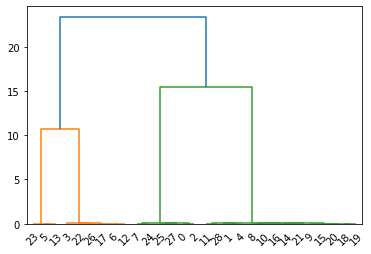

In [49]:
from scipy.cluster import hierarchy
from scipy.spatial import distance_matrix

X1 = dataframe_filtered[['lat','lng','dum_hicat']]

dist_matrix = distance_matrix(X1,X1)
Z = hierarchy.linkage(dist_matrix, 'ward')
dendro = hierarchy.dendrogram(Z)

Linkage method | Working clusters numbers
:-----         | :----:
Ward           | [2,3,4] - Better:4
Complete       | [2,4] - Better:4
Average        | [2,4] - Better:4

From all cases, `ward` linkage method with 4 clusters seems to be a better good choice.

##### Fitting model

In [50]:
from sklearn.cluster import AgglomerativeClustering

# ML algo
agglom = AgglomerativeClustering(n_clusters = 4, linkage = 'ward')
agglom.fit(dataframe_filtered[['lat','lng','dum_hicat']])

# Allocate cluster labels
dataframe_filtered['hier_cluster_lab'] = agglom.labels_

# Sort df to create a legend map ordered
dataframe_filtered.sort_values('hier_cluster_lab', inplace=True)

##### Results

In [51]:
# Create empty canvas
pivot_df = pd.DataFrame(index=dataframe_filtered['hier_cluster_lab'].unique(),
                        columns=dataframe_filtered['hicategories'].unique()).sort_index()

# Get counts by category and cluster label
count_lab = dataframe_filtered[['hicategories','hier_cluster_lab']].value_counts()

# Fill pivot table with counts
for num, idx in enumerate(count_lab.index):
    pivot_df.loc[idx[1], idx[0]] = count_lab[num]

# Adding marginal values
pivot_df.at['Sum',:] = pivot_df.sum()
pivot_df.at[:,'Sum'] = pivot_df.sum(1).astype(int)

# Contingency table
prop_pivot_df = pivot_df.iloc[0:4,0:5] / pivot_df.iloc[0:4,0:5].sum()

Next are tables (absolute and relative) showing how much each venue category is divided among the 4 different cluster (cluster labels are tables indexes).

In [52]:
# Absolute table
pivot_df

,play,exposition-formation,show,monument,Sum
0,6,NaN,NaN,NaN,6
1,NaN,6,NaN,NaN,6
2,NaN,NaN,14,NaN,14
3,NaN,NaN,NaN,3,3
Sum,6,6,14,3,29


In [53]:
# Proportion table
prop_pivot_df

,play,exposition-formation,show,monument,Sum
0,1,NaN,NaN,NaN,0.206897
1,NaN,1,NaN,NaN,0.206897
2,NaN,NaN,1,NaN,0.482759
3,NaN,NaN,NaN,1,0.103448


This method is completely driven by the category variable and only points out the same result as the one in exploratory analysis in the data collecting stage.  
Thus, the map view is redundant and unnecessary.

#### DBScan

To maybe find a different result, a density-based clustering model is applied.

##### Fitting model

In [54]:
# Preprocess step to better tweak ML algo para
X = dataframe_filtered[['lat','lng','dum_hicat']]
X = StandardScaler().fit_transform(X)

db = DBSCAN(eps=0.7, min_samples=3).fit(X)

# Allocation of cluster labels
dataframe_filtered['dbscan_cluster_lab'] = db.labels_

# Sort df to create a legend map ordered
dataframe_filtered.sort_values('dbscan_cluster_lab', inplace=True)

##### Results

In [55]:
# Create empty canvas
pivot_df = pd.DataFrame(index=dataframe_filtered['dbscan_cluster_lab'].unique(),
                        columns=dataframe_filtered['hicategories'].unique()).sort_index()

# Get counts by category and cluster label
count_lab = dataframe_filtered[['hicategories','dbscan_cluster_lab']].value_counts()

# Fill pivot table with counts
for num, idx in enumerate(count_lab.index):
    pivot_df.loc[idx[1], idx[0]] = count_lab[num]

# Adding marginal values
pivot_df.at['Sum',:] = pivot_df.sum()
pivot_df.at[:,'Sum'] = pivot_df.sum(1).astype(int)

# Contingency table
prop_pivot_df = pivot_df.iloc[0:3,0:5] / pivot_df.iloc[0:3,0:5].sum()

In [56]:
# Absolute table
pivot_df

,play,monument,show,exposition-formation,Sum
-1,6,3,6,3,18
0,NaN,NaN,NaN,3,3
1,NaN,NaN,8,NaN,8
Sum,6,3,14,6,29


In [57]:
# Proportion table
prop_pivot_df

,play,monument,show,exposition-formation,Sum
-1,1,1,0.428571,0.5,0.620690
0,NaN,NaN,NaN,0.5,0.103448
1,NaN,NaN,0.571429,NaN,0.275862


Almost all data points are outliers, yet two clusters exist.  

Both are made exclusively by category venue, and among them, again `show` category cluster is present, cluster 1. Which have the same amount of cultural places, 8 *(57%)*, as the clustering made the hierarchical method only with latitude and longitude (but not all the same places).

The map view is of little interest, but it is preferable to create it:

In [58]:
# ------------------------------
keys = list(dataframe_filtered['dbscan_cluster_lab'].unique())
color_range = list(np.linspace(0, 1, len(keys), endpoint=False))

colors = [cm.colors.to_hex(cm.tab10(x)) for x in color_range]
color_dict = dict(zip(keys, colors)) 

# ------------------------------
# Create FeatureGroup to add a legend layer
folium_lgd = dict()
for col, cat in zip(colors, keys):
    folium_lgd[cat] = folium.FeatureGroup(name='<span style=\\"color: {col};\\">Cluster {cat}</span>'.format(col=col, cat=cat))

# ------------------------------

# Initial layout map
toulouse_map = folium.Map(location=[lat_tls, lng_tls], zoom_start=15, tiles="cartoDB positron")

# Adding cultural venues
for lat, lng, name, cat, clust in zip(dataframe_filtered['lat'], dataframe_filtered['lng'],
                               dataframe_filtered['name'], dataframe_filtered['hicategories'],
                               dataframe_filtered['dbscan_cluster_lab']):
    label = '{} | {}'.format(name, cat)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=9,
        popup=label,
        fill=True,
        opacity=0,
        fill_color=color_dict[clust],
        fill_opacity=0.8,
        parse_html=False).add_to(folium_lgd[clust])
    folium_lgd[clust].add_to(toulouse_map)

folium.map.LayerControl('topright', collapsed=False).add_to(toulouse_map)

# Show map
toulouse_map

Without surprise, there is almost the same upper right cluster as ones shown by previous map views, and exclusively made out of `show` venues.

**This somewhat disappointing analysis shows nothing more than what has already been explained. In addition, cultural categories almost has a detrimental effect on the clustering process compared to one that only takes into account the geographic position.**

### Adding pedestrian flow counts in clustering algorithm

Now, let's see how the counting of pedestrian flows influences the clustering of cultural places.

#### Hierarchical clustering

##### Best fit

Same as the previous similar step, a linkage method and cluster number is chosen from multiple runs of dendrograms plots. All plots, unless one for demonstration, are skipped and all results are recapitulated in a table.

However, this time another variable is present: metrics pedestrian flow counts. Indeed, the clustering can be different if only the minimum flow count in the venue proximity area is chosen instead of the median value or both measures.

Also, it's important to remember that on pedestrian flow counts near venues dataframe only gets 2 categories. 

**So, lower venues and a minimum amount of categories could lead to very different result, if not nonexistent.**

<ipython-input-59-1d680525de36>:11: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(dist_matrix, 'ward')


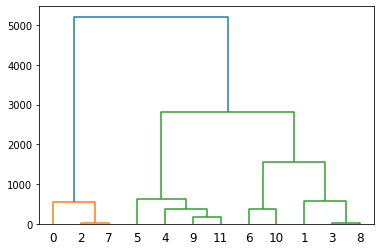

In [59]:
from scipy.cluster import hierarchy
from scipy.spatial import distance_matrix

# X1 = venu_prox[['lat','lng']]
# X1 = venu_prox[['lat','lng','show_cat']]
# X1 = venu_prox[['lat','lng','show_cat','min_pedcount']]
X1 = venu_prox[['lat','lng','show_cat','median_pedcount']]
# X1 = venu_prox[['lat','lng','show_cat','min_pedcount','median_pedcount']]

dist_matrix = distance_matrix(X1,X1)
Z = hierarchy.linkage(dist_matrix, 'ward')
dendro = hierarchy.dendrogram(Z)

Linkage method | Base   | Category | Minimum flow count | Median flow count | Both flow counts metrics
:-----         | :----: | :-----:  | :----:             | :-----:           | :-----:
Ward           | [4,6] - Better:4 | [1,2] - Better: 2 | [3,4] - Better: 4 | [3,4] - Better: 4 | [4,6] - Better: 4
Complete       | [4,6] - Better:4 | [1,2] - Better: 2 | [3,4] - Better: 4 | [3,4] - Better: 4 | [3,4,6] - Better: 4
Average        | [3,5] - Better:3 | [1,2] - Better: 2 | [3,4] - Better: 4 | [3,4] - Better: 4 | [3,4,6] - Better: 6
Hierarchical distance | Bad | Good | Good + | Good + | Medium

From all cases, `ward` linkage method with 4 clusters and only median flow count as the chosen metric seems to be a very good choice.

##### Fitting model

In [60]:
agglom = AgglomerativeClustering(n_clusters = 4, linkage = 'ward')

agglom.fit(X1)

venu_prox['hier_cluster_lab'] = agglom.labels_

# Sort df to create a legend map ordered
venu_prox.sort_values('hier_cluster_lab', inplace=True)

##### Results

In [61]:
# Create empty canvas
pivot_df = pd.DataFrame(index=venu_prox['hier_cluster_lab'].unique(),
                        columns=venu_prox['hicategories'].unique()).sort_index()

# Get counts by category and cluster label
count_lab = venu_prox[['hicategories','hier_cluster_lab']].value_counts()

# Fill pivot table with counts
for num, idx in enumerate(count_lab.index):
    pivot_df.loc[idx[1], idx[0]] = count_lab[num]

# Adding marginal values
pivot_df.at['Sum',:] = pivot_df.sum()
pivot_df.at[:,'Sum'] = pivot_df.sum(1).astype(int)

# Contingency table
prop_pivot_df = pivot_df.iloc[0:4,0:3] / pivot_df.iloc[0:4,0:3].sum()

In [62]:
# Absolute table
pivot_df

,show,exposition-formation,Sum
0,4,NaN,4
1,2,1,3
2,NaN,3,3
3,1,1,2
Sum,7,5,12


In [63]:
# Proportion table
prop_pivot_df

,show,exposition-formation,Sum
0,0.571429,NaN,0.333333
1,0.285714,0.2,0.250000
2,NaN,0.6,0.250000
3,0.142857,0.2,0.166667


Among the 4 clusters, the two venue categories are mainly distributed in a different cluster.  
It is also interesting to note that the major proportion (but not the amount) of `show`, 57%, is the same as the one observed in hierarchical clustering with only location variable.  

However, with fewer data points, the usual upper right cluster mostly made of `show` probably remains but must be heavily sliced. Here's the map view:

In [64]:
# ------------------------------
keys = list(venu_prox['hier_cluster_lab'].unique())
color_range = list(np.linspace(0, 1, len(keys), endpoint=False))

colors = [cm.colors.to_hex(cm.tab10(x)) for x in color_range]
color_dict = dict(zip(keys, colors)) 

# ------------------------------
# Create FeatureGroup to add a legend layer
folium_lgd = dict()
for col, cat in zip(colors, keys):
    folium_lgd[cat] = folium.FeatureGroup(name='<span style=\\"color: {col};\\">Cluster {cat}</span>'.format(col=col, cat=cat))

# ------------------------------

# Initial layout map
toulouse_map = folium.Map(location=[lat_tls, lng_tls], zoom_start=15, tiles="cartoDB positron")

# Adding cultural venues
for lat, lng, name, cat, met, clust in zip(venu_prox['lat'], venu_prox['lng'],
                               venu_prox['name'], venu_prox['hicategories'],
                               venu_prox['median_pedcount'], venu_prox['hier_cluster_lab']):
    label = '''{} | {} | {}'''.format(name, cat, met)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=9,
        popup=label,
        fill=True,
        opacity=0,
        fill_color=color_dict[clust],
        fill_opacity=0.8,
        parse_html=False).add_to(folium_lgd[clust])
    folium_lgd[clust].add_to(toulouse_map)

folium.map.LayerControl('topright', collapsed=False).add_to(toulouse_map)

# Show map
toulouse_map

From the previous upper right cluster, only its shadow remains. 

**The median of the pedestrian flow counts plays an important role in the clustering effect, probably more than category feature.**  

Indeed,
+ cluster 0, `show` exclusive, group flow counts between [1100, 1350]
+ cluster 1, gets [1800, 1950] values
+ cluster 2, gets [800, 950] values
+ cluster 3, gets [550, 650] values

**This data points and method doesn't show relevant or different conclusions from before. For now, adding pedestrian flow counts is too much impacting the data by reducing it. Thus, unfortunately but expected, this analysis is inconclusive.**

#### DBScan

To complete the initial methodology and maybe find a different result, a density-based clustering model is applied.

##### Fitting model

In [65]:
# Preprocess step to better tweak ML algo para
X = StandardScaler().fit_transform(X1)

db = DBSCAN(eps=1.3, min_samples=2).fit(X)

# Allocation of cluster labels
venu_prox['dbscan_cluster_lab'] = db.labels_

# Sort df to create a legend map ordered
venu_prox.sort_values('dbscan_cluster_lab', inplace=True)

##### Results

In [66]:
# Create empty canvas
pivot_df = pd.DataFrame(index=venu_prox['dbscan_cluster_lab'].unique(),
                        columns=venu_prox['hicategories'].unique()).sort_index()

# Get counts by category and cluster label
count_lab = venu_prox[['hicategories','dbscan_cluster_lab']].value_counts()

# Fill pivot table with counts
for num, idx in enumerate(count_lab.index):
    pivot_df.loc[idx[1], idx[0]] = count_lab[num]

# Adding marginal values
pivot_df.at['Sum',:] = pivot_df.sum()
pivot_df.at[:,'Sum'] = pivot_df.sum(1).astype(int)

# Contingency table
prop_pivot_df = pivot_df.iloc[0:4,0:5] / pivot_df.iloc[0:4,0:5].sum()

In [67]:
# Absolute table
pivot_df

,show,exposition-formation,Sum
-1,2,3,5
0,1,1,2
1,2,NaN,2
2,2,1,3
Sum,7,5,12


In [68]:
# Proportion table
prop_pivot_df

,show,exposition-formation,Sum
-1,0.285714,0.6,0.416667
0,0.142857,0.2,0.166667
1,0.285714,NaN,0.166667
2,0.285714,0.2,0.250000


Half points are outliers and the rest are equally distributed among the 3 clusters.

**This method is worthless than the hierarchical, and not better conclusion can be made.**

The map view is of little interest, but it is preferable to create it:

In [69]:
# ------------------------------
keys = list(venu_prox['dbscan_cluster_lab'].unique())
color_range = list(np.linspace(0, 1, len(keys), endpoint=False))

colors = [cm.colors.to_hex(cm.tab10(x)) for x in color_range]
color_dict = dict(zip(keys, colors)) 

# ------------------------------
# Create FeatureGroup to add a legend layer
folium_lgd = dict()
for col, cat in zip(colors, keys):
    folium_lgd[cat] = folium.FeatureGroup(name='<span style=\\"color: {col};\\">Cluster {cat}</span>'.format(col=col, cat=cat))

# ------------------------------

# Initial layout map
toulouse_map = folium.Map(location=[lat_tls, lng_tls], zoom_start=15, tiles="cartoDB positron")

# Adding cultural venues
for lat, lng, name, cat, met, clust in zip(venu_prox['lat'], venu_prox['lng'],
                               venu_prox['name'], venu_prox['hicategories'],
                               venu_prox['median_pedcount'], venu_prox['dbscan_cluster_lab']):
    label = '''{} | {} | {}'''.format(name, cat, met)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=9,
        popup=label,
        fill=True,
        opacity=0,
        fill_color=color_dict[clust],
        fill_opacity=0.8,
        parse_html=False).add_to(folium_lgd[clust])
    folium_lgd[clust].add_to(toulouse_map)

folium.map.LayerControl('topright', collapsed=False).add_to(toulouse_map)

# Show map
toulouse_map

**This even more disappointing analysis shows nothing more than what has already been explained. Unfortunately, pedestrian flow counts doesn't suit well with Foursquare cultural venues dataset in order to find some clusters.**

## Conclusion